In [1]:
def convert_loom_to_anndata(loom_file, ca_list=[], ra_list=[], ca_index='CellID', ra_index='Accession'):
    attr_lists = [ca_list, ra_list]
    
    # if attr lists are empy, keep original columns/rows
    for idx, attr_list in enumerate(attr_lists):
        if len(attr_lists[idx]) == 0:
            if idx == 0: 
                attr_lists[idx] = loom_file.ca.keys()
            elif idx == 1: 
                attr_lists[idx] = loom_file.ra.keys()
    
    # select index columns for the dataframes
    attr_indexes = [ca_index, ra_index]
    for idx, index in enumerate(attr_indexes):
        if type(index) == int:
            attr_indexes[idx] = attr_lists[idx][index]
        elif type(index) == str:
            assert index in attr_lists[idx]
    print(f'The indeces for var and obs will be assigned to {attr_indexes[0]} and {attr_indexes[1]}')
    
    # create var and obs dataframes with defined columns and indexes (indices)
    ad_attr = [pd.DataFrame(), pd.DataFrame()]
    for idx, attr_list in enumerate(attr_lists):
        for attr in attr_list:
            if idx == 0: 
                ad_attr[idx][attr] = loom_file.ca[attr]
            elif idx == 1: 
                ad_attr[idx][attr] = loom_file.ra[attr]
        ad_attr[idx].index = ad_attr[idx][attr_indexes[idx]]

    adata = ad.AnnData(X = loom_file[:, :].T, var=ad_attr[1], obs=ad_attr[0])
        
    return adata

In [2]:
import pickle
from datetime import date
import os
import loompy
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
from src.classes import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
today = date.today()
print(today)

input_folder = '../../data/stereoscope_reference/single_cell_data/original/Linnarsson_mouse_brain_all/'

output_path = '../../data/stereoscope_reference/single_cell_data/'
output_folder = f'{output_path}L5_{today.strftime("%d%m%y")}/'
print(output_folder)
os.makedirs(output_folder, exist_ok=True)

2022-10-10
../../data/stereoscope_reference/single_cell_data/L5_101022/


In [8]:
# if you have problems with loading a package, check  if it is installed in the environment
!conda list | grep "loompy"

loompy                    3.0.7                    pypi_0    pypi


In [9]:
L5_all = loompy.connect(f'{input_folder}L5_All.loom')
L5_all

,,,,,,,,Age,"p21, p23","p21, p23","p21, p23","p21, p23","p21, p23","p21, p23","p19, p21","p19, p21","p21, p23","p19, p21",...
,,,,,,,,AnalysisPool,Enteric,Enteric,Enteric,Enteric,Enteric,Enteric,Enteric,Enteric,Enteric,Enteric,...
,,,,,,,,AnalysisProject,Adolescent,Adolescent,Adolescent,Adolescent,Adolescent,Adolescent,Adolescent,Adolescent,Adolescent,Adolescent,...
,,,,,,,,Bucket,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,/Users/sten/build_20171205/L4_Enteric_Neurons.loom,...
,,,,,,,,CellConc,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...
,,,,,,,,CellID,10X82_2_TCTCTCACCAGTTA-,10X82_2_TATTATCTACCAGA-,10X82_2_TATCCCAGATGGCA-,10X82_2_ATTACGTATGAATG-,10X82_2_ATACGTCAATAAGG-,10X82_2_TACAGTCTTCGGTC-,10X81_2_CGTAACATTCGACA-,10X81_3_TGATGAGATACACA-,10X82_2_GCCAGGTAGGACAC-,10X81_2_AGATCAGTCCGTAT-,...
,,,,,,,,ChipID,10X82,10X82,10X82,10X82,10X82,10X82,10X81,10X81,10X82,10X81,...
,,,,,,,,Class,Neurons,Neurons,Neurons,Neurons,Neurons,Neurons,Neurons,Neurons,Neurons,Neurons,...
,,,,,,,,ClassProbability_Astrocyte,0.0019066928357193203,0.0016280432367160702,0.001442371119771456,0.0014588527727608211,0.0013114769769024266,0.001401728372893371,0.0015184785192116678,0.0016035799690204849,0.0014427321058514797,0.0014199397313300632,...
,,,,,,,,"ClassProbability_Astrocyte,Immune",0.00048062321574226374,0.0004227793201626071,0.0003650463779465638,0.0003772070059891973,0.0003417394428646381,0.0003580446839276589,0.00040760794015975554,0.00043385576285106896,0.0003785113441852317,0.00038650050961498917,...
,,,,,,,,"ClassProbability_Astrocyte,Neurons",0.0025533596211774617,0.0023433597390213642,0.0021114112935140326,0.0021700394870497754,0.0020681886584825023,0.0020929032661028517,0.002376750903863037,0.0024868854826892712,0.0021762483715224044,0.002345536255842545,...


In [10]:
ca_selection = ['Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on',                         'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region',
                         'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID',
                'SampleID', 'SampleIndex', 'PCRCycles', 'Strain']
ra_selection = ['Accession', 'Gene', 'Gene_no_alt']

### Included in reference dataset

For the observation, I keep:
* Accession
* Gene
* Gene_no_alt

For variables, I keep:
* Age
* AnalysisPool
* CellID
* Class
* ClusterName
* Description
* Location_based_on
* Mean Reads per Cell
* Median UMI Counts per Cell
* Neurotransmitter
* Region
* TaxonomyRank1
* TaxonomyRank2
* TaxonomyRank3
* TaxonomyRank4
* bio_celltype

In [11]:
adata_all = convert_loom_to_anndata(L5_all, ca_list=ca_selection, ra_list=ra_selection)
adata_all

The indeces for var and obs will be assigned to CellID and Accession


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 160796 × 27998
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain'
    var: 'Accession', 'Gene', 'Gene_no_alt'

In [12]:
L5_all.close()

In [4]:
pickle_loc = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/data/stereoscope_reference/single_cell_data/original/Linnarsson_mouse_brain_all/L5_all_subset_notation.pkl'

In [14]:
# save pickle if you want
with open(pickle_loc, 'wb') as pickle_file:
    pickle.dump(adata_all, pickle_file)

In [5]:
with open(pickle_loc, 'rb') as pickle_file:
    adata_all = pickle.load(pickle_file)
adata_all

AnnData object with n_obs × n_vars = 160796 × 27998
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain'
    var: 'Accession', 'Gene', 'Gene_no_alt'

In [29]:
# These are all the availabel cell annotations from TaxonomyRank4 (a sweetspot in between too much and too little description...)
adata_all.obs['TaxonomyRank4'].value_counts()

Oligodendrocytes                               30253
Astrocytes                                     19377
Telencephalon projecting excitatory neurons    18799
Enteric glia                                   10535
Telencephalon inhibitory interneurons           8637
Di- and mesencephalon excitatory neurons        6455
Telencephalon projecting inhibitory neurons     5691
Microglia                                       5425
Cerebellum neurons                              5292
Pericytes                                       5213
Olfactory inhibitory neurons                    5191
Non-glutamatergic neuroblasts                   4822
Dentate gyrus granule neurons                   4368
Di- and mesencephalon inhibitory neurons        4026
Vascular endothelial cells                      3805
Peptidergic neurons                             2906
Olfactory ensheathing cells                     2031
Perivascular macrophages                        2029
Vascular smooth muscle cells                  

In [7]:
# clusters that we want to focus on
celltypes_to_keep_dict  = {
    'MBDOP2': 'Dopaminergic neurons; mouse' , 
    'MBDOP1': 'Dopaminergic neurons; mouse' , 
    'MOL1': 'Oligodendrocytes',
    'COP1': 'Oligodendrocytes',
    'MFOL1': 'Oligodendrocytes',
    'MFOL2': 'Oligodendrocytes',
    'MSN1': 'D1 Medium Spiny Neurons; mouse',
    'MSN2': 'D2 Medium Spiny Neurons; mouse',
    'MSN3': 'D2 Medium Spiny Neurons; mouse',
    'MSN4': 'D1 Medium Spiny Neurons; mouse',
    'MSN5': 'D1/D2 Medium Spiny Neurons, striatum',
    'MSN6': 'D1 Medium Spiny Neurons; mouse',
    'TEGLU1': 'Cortical projection neurons; mouse',
    'TEGLU2': 'Cortical projection neurons; mouse',
    'TEGLU3': 'Cortical projection neurons; mouse',
    'TEGLU4': 'Cortical projection neurons; mouse',
    'TEGLU5': 'Cortical projection neurons; mouse',
    'TEGLU6': 'Cortical projection neurons; mouse',
    'TEGLU7': 'Cortical projection neurons; mouse',
    'TEGLU8': 'Cortical projection neurons; mouse',
    'TEGLU9': 'Cortical projection neurons; mouse',
    'TEGLU10': 'Cortical projection neurons; mouse',
    'TEGLU11': 'Cortical projection neurons; mouse',
    'TEGLU12': 'Cortical projection neurons; mouse',
    'TEGLU13': 'Cortical projection neurons; mouse',
    'TEGLU14': 'Cortical projection neurons; mouse',
    'TEGLU15': 'Cortical projection neurons; mouse',
    'TEGLU16': 'Cortical projection neurons; mouse',
    'TEGLU17': 'Cortical projection neurons; mouse',
    'TEGLU18': 'Cortical projection neurons; mouse',
    'TEGLU19': 'Cortical projection neurons; mouse',
    'TEGLU20': 'Cortical projection neurons; mouse',
    'TECHO': 'Cholinergic interneurons; mouse',
    'DECHO1': 'Cholinergic interneurons; mouse',
    'VLMC1': 'Vascular leptomeningeal cells; mouse',
    'VLMC2': 'Vascular leptomeningeal cells; mouse',
    'ABC': 'Vascular leptomeningeal cells; mouse',
    'ACTE1': 'Telencephalon astrocytes, fibrous; mouse',
    'ACTE2': 'Telencephalon astrocytes, protoplasmic; mouse',
    'ACMB': 'Dorsal midbrain Myoc-expressing astrocyte-like; mouse',
    'ACNT1': 'Non-telencephalon astrocytes, protoplasmic; mouse',
    'ACNT2': 'Non-telencephalon astrocytes, fibrous; mouse',
    'VECA' : 'Vascular; mouse',
    'VSMCA' : 'Vascular; mouse',
    'PER1' : 'Vascular; mouse',
    'PER2' : 'Vascular; mouse',
    'PER3' : 'Vascular; mouse',
    'VECC' : 'Vascular; mouse',
    'VECV' : 'Vascular; mouse',
    'PVM1' : 'Immune cells; mouse',
    'PVM2' : 'Immune cells; mouse',
    'MGL3' : 'Immune cells; mouse',
    'MGL2' : 'Immune cells; mouse',
    'MGL1' : 'Immune cells; mouse',
    'RGDG' : 'Dentate gyrus radial glia-like cells',
    'RGSZ' : 'Subventricular zone radial glia-like cells',
    'SEPNBL': 'Neuroblasts'
}

celltypes_to_discard = ['Ependymal cells']
# supplemented by Taxonomy Rank 4 (or any other column) anotation
annotated_column, annotation_column = 'ClusterName', 'Description'
annot_cluster = adata_all.obs[[annotated_column, annotation_column]]
annot_dict = annot_cluster.groupby(annotated_column).first().to_dict()[annotation_column]

In [6]:
# merge astrocytes
# clusters that we want to focus on
celltypes_to_keep_dict  = {
    'MBDOP2': 'Dopaminergic neurons; mouse' , 
    'MBDOP1': 'Dopaminergic neurons; mouse' , 
    'MOL1': 'Oligodendrocytes',
    'COP1': 'Oligodendrocytes',
    'MFOL1': 'Oligodendrocytes',
    'MFOL2': 'Oligodendrocytes',
    'MSN1': 'D1 Medium Spiny Neurons; mouse',
    'MSN2': 'D2 Medium Spiny Neurons; mouse',
    'MSN3': 'D2 Medium Spiny Neurons; mouse',
    'MSN4': 'D1 Medium Spiny Neurons; mouse',
    'MSN5': 'D1/D2 Medium Spiny Neurons, striatum',
    'MSN6': 'D1 Medium Spiny Neurons; mouse',
    'TEGLU1': 'Cortical projection neurons; mouse',
    'TEGLU2': 'Cortical projection neurons; mouse',
    'TEGLU3': 'Cortical projection neurons; mouse',
    'TEGLU4': 'Cortical projection neurons; mouse',
    'TEGLU5': 'Cortical projection neurons; mouse',
    'TEGLU6': 'Cortical projection neurons; mouse',
    'TEGLU7': 'Cortical projection neurons; mouse',
    'TEGLU8': 'Cortical projection neurons; mouse',
    'TEGLU9': 'Cortical projection neurons; mouse',
    'TEGLU10': 'Cortical projection neurons; mouse',
    'TEGLU11': 'Cortical projection neurons; mouse',
    'TEGLU12': 'Cortical projection neurons; mouse',
    'TEGLU13': 'Cortical projection neurons; mouse',
    'TEGLU14': 'Cortical projection neurons; mouse',
    'TEGLU15': 'Cortical projection neurons; mouse',
    'TEGLU16': 'Cortical projection neurons; mouse',
    'TEGLU17': 'Cortical projection neurons; mouse',
    'TEGLU18': 'Cortical projection neurons; mouse',
    'TEGLU19': 'Cortical projection neurons; mouse',
    'TEGLU20': 'Cortical projection neurons; mouse',
    'TECHO': 'Cholinergic interneurons; mouse',
    'DECHO1': 'Cholinergic interneurons; mouse',
    'VLMC1': 'Vascular leptomeningeal cells; mouse',
    'VLMC2': 'Vascular leptomeningeal cells; mouse',
    'ABC': 'Vascular leptomeningeal cells; mouse',
    'ACTE1': 'Astrocytes; mouse',
    'ACTE2': 'Astrocytes; mouse',
    'ACMB': 'Astrocytes; mouse',
    'ACNT1': 'Astrocytes; mouse',
    'ACNT2': 'Astrocytes; mouse',
    'VECA' : 'Vascular; mouse',
    'VSMCA' : 'Vascular; mouse',
    'PER1' : 'Vascular; mouse',
    'PER2' : 'Vascular; mouse',
    'PER3' : 'Vascular; mouse',
    'VECC' : 'Vascular; mouse',
    'VECV' : 'Vascular; mouse',
    'PVM1' : 'Immune cells; mouse',
    'PVM2' : 'Immune cells; mouse',
    'MGL3' : 'Immune cells; mouse',
    'MGL2' : 'Immune cells; mouse',
    'MGL1' : 'Immune cells; mouse',
    'RGDG' : 'Dentate gyrus radial glia-like cells',
    'RGSZ' : 'Subventricular zone radial glia-like cells',
    'SEPNBL': 'Neuroblasts'
}

celltypes_to_discard = ['Ependymal cells']
# supplemented by Taxonomy Rank 4 (or any other column) anotation
annotated_column, annotation_column = 'ClusterName', 'Description'
annot_cluster = adata_all.obs[[annotated_column, annotation_column]]
annot_dict = annot_cluster.groupby(annotated_column).first().to_dict()[annotation_column]

In [8]:
# merge astrocytes and separate dopaminergic clusters
# clusters that we want to focus on
celltypes_to_keep_dict  = {
    'MBDOP2': 'Dopaminergic neurons, SN, VTA; mouse' , 
    'MBDOP1': 'Dopaminergic neurons, periaqueductal grey; mouse' , 
    'MOL1': 'Oligodendrocytes',
    'COP1': 'Oligodendrocytes',
    'MFOL1': 'Oligodendrocytes',
    'MFOL2': 'Oligodendrocytes',
    'MSN1': 'D1 Medium Spiny Neurons; mouse',
    'MSN2': 'D2 Medium Spiny Neurons; mouse',
    'MSN3': 'D2 Medium Spiny Neurons; mouse',
    'MSN4': 'D1 Medium Spiny Neurons; mouse',
    'MSN5': 'D1/D2 Medium Spiny Neurons, striatum',
    'MSN6': 'D1 Medium Spiny Neurons; mouse',
    'TEGLU1': 'Cortical projection neurons; mouse',
    'TEGLU2': 'Cortical projection neurons; mouse',
    'TEGLU3': 'Cortical projection neurons; mouse',
    'TEGLU4': 'Cortical projection neurons; mouse',
    'TEGLU5': 'Cortical projection neurons; mouse',
    'TEGLU6': 'Cortical projection neurons; mouse',
    'TEGLU7': 'Cortical projection neurons; mouse',
    'TEGLU8': 'Cortical projection neurons; mouse',
    'TEGLU9': 'Cortical projection neurons; mouse',
    'TEGLU10': 'Cortical projection neurons; mouse',
    'TEGLU11': 'Cortical projection neurons; mouse',
    'TEGLU12': 'Cortical projection neurons; mouse',
    'TEGLU13': 'Cortical projection neurons; mouse',
    'TEGLU14': 'Cortical projection neurons; mouse',
    'TEGLU15': 'Cortical projection neurons; mouse',
    'TEGLU16': 'Cortical projection neurons; mouse',
    'TEGLU17': 'Cortical projection neurons; mouse',
    'TEGLU18': 'Cortical projection neurons; mouse',
    'TEGLU19': 'Cortical projection neurons; mouse',
    'TEGLU20': 'Cortical projection neurons; mouse',
    'TECHO': 'Cholinergic interneurons; mouse',
    'DECHO1': 'Cholinergic interneurons; mouse',
    'VLMC1': 'Vascular leptomeningeal cells; mouse',
    'VLMC2': 'Vascular leptomeningeal cells; mouse',
    'ABC': 'Vascular leptomeningeal cells; mouse',
    'ACTE1': 'Astrocytes; mouse',
    'ACTE2': 'Astrocytes; mouse',
    'ACMB': 'Astrocytes; mouse',
    'ACNT1': 'Astrocytes; mouse',
    'ACNT2': 'Astrocytes; mouse',
    'VECA' : 'Vascular; mouse',
    'VSMCA' : 'Vascular; mouse',
    'PER1' : 'Vascular; mouse',
    'PER2' : 'Vascular; mouse',
    'PER3' : 'Vascular; mouse',
    'VECC' : 'Vascular; mouse',
    'VECV' : 'Vascular; mouse',
    'PVM1' : 'Immune cells; mouse',
    'PVM2' : 'Immune cells; mouse',
    'MGL3' : 'Immune cells; mouse',
    'MGL2' : 'Immune cells; mouse',
    'MGL1' : 'Immune cells; mouse',
    'RGDG' : 'Dentate gyrus radial glia-like cells',
    'RGSZ' : 'Subventricular zone radial glia-like cells',
    'SEPNBL': 'Neuroblasts'
}

celltypes_to_discard = ['Ependymal cells']
# supplemented by Taxonomy Rank 4 (or any other column) anotation
annotated_column, annotation_column = 'ClusterName', 'Description'
annot_cluster = adata_all.obs[[annotated_column, annotation_column]]
annot_dict = annot_cluster.groupby(annotated_column).first().to_dict()[annotation_column]   

In [7]:
adata_all.obs['Celltype_assigned'] = adata_all.obs['ClusterName'].replace(celltypes_to_keep_dict).replace(annot_dict)
adata_all.obs['Celltype_assigned'].value_counts(sort=True)

Astrocytes; mouse                          17018
Oligodendrocytes                           16346
Cortical projection neurons; mouse         15216
Vascular; mouse                            10646
Enteric glia                               10323
                                           ...  
Peptidergic (PEP1.2), DRG                     30
Noradrenergic neurons of the medulla          23
Granular layer interneurons, cerebellum       17
Pmch neurons, hypothalamus                    13
Neuroblast-like, habenula                      7
Name: Celltype_assigned, Length: 117, dtype: int64

adata_all = merge_gene_symbol_duplicates(adata_all, symbol_column='Gene_no_alt')
adata_all.var.index = adata_all.var['Gene_no_alt']
adata_all.var.index.name = 'symbol'
adata_all.var

### Regions included in the dataset

Here we select, which regions do we want to have included in the dataset.
In my case, I chose all regions with striatum, cortex, midbrain, 'CNS' and Pallidum

In [8]:
selected_regions = ['Striatum', 'Midbrain ventral', 'Cortex']
adata_selected = adata_all[adata_all.obs['Region'].str.contains('|'.join(selected_regions)) | 
                           adata_all.obs['ClusterName'].str.contains('|'.join(celltypes_to_keep_dict.keys())) , :]
# adata_selected = adata_selected[adata_selected.obs['Celltype_assigned'] != 'Ependymal cells', :]
adata_selected

View of AnnData object with n_obs × n_vars = 89519 × 27998
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain', 'Celltype_assigned'
    var: 'Accession', 'Gene', 'Gene_no_alt'

In [10]:
del adata_all

In [9]:
adata_selected.var

,Accession,Gene,Gene_no_alt
Accession,,,
ENSMUSG00000024647,ENSMUSG00000024647,Cbln2,CBLN2
ENSMUSG00000041544,ENSMUSG00000041544,Ptchd2,PTCHD2
ENSMUSG00000029503,ENSMUSG00000029503,P2rx2,P2RX2
ENSMUSG00000039942,ENSMUSG00000039942,Ptger4,PTGER4
ENSMUSG00000059187,ENSMUSG00000059187,Fam19a1,FAM19A1
...,...,...,...
ENSMUSG00000098197,ENSMUSG00000098197,BC051537,BC051537
ENSMUSG00000087066,ENSMUSG00000087066,Gm15518,GM15518
ENSMUSG00000026766,ENSMUSG00000026766,Mmadhc,MMADHC


In [11]:
# This makes it a “real” AnnData object
adata_selected.obs["value"] = 0 

/tmp/ipykernel_31745/4040885219.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_selected.obs["value"] = 0
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
adata_selected = merge_gene_symbol_duplicates(adata_selected, symbol_column='Gene_no_alt')
adata_selected.var.index = adata_selected.var['Gene_no_alt']
adata_selected.var.index.name = 'symbol'
adata_selected.var

Scaled from 27998 genes incl. alternative splicing to 27794 genes without alternative splicing variants


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,Accession,Gene,Gene_no_alt,value
symbol,,,,
0610007P14RIK,ENSMUSG00000021252,0610007P14Rik,0610007P14RIK,0
0610009B22RIK,ENSMUSG00000007777,0610009B22Rik,0610009B22RIK,0
0610009L18RIK,ENSMUSG00000043644,0610009L18Rik,0610009L18RIK,0
0610009O20RIK,ENSMUSG00000024442,0610009O20Rik,0610009O20RIK,0
0610010F05RIK,ENSMUSG00000042208,0610010F05Rik,0610010F05RIK,0
...,...,...,...,...
ZYG11A,ENSMUSG00000034645,Zyg11a,ZYG11A,0
ZYG11B,ENSMUSG00000034636,Zyg11b,ZYG11B,0
ZYX,ENSMUSG00000029860,Zyx,ZYX,0


In [13]:
adata_selected.obs.columns

Index(['Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description',
       'Location_based_on', 'Mean Reads per Cell',
       'Median UMI Counts per Cell', 'Neurotransmitter', 'Region',
       'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4',
       'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles',
       'Strain', 'Celltype_assigned', 'value'],
      dtype='object')

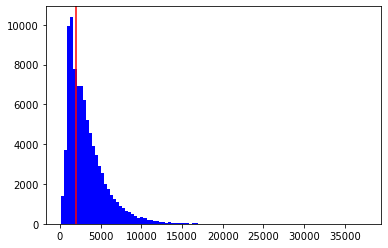

Astrocytes; mouse                                                       17018
Oligodendrocytes                                                        16346
Cortical projection neurons; mouse                                      15216
Vascular; mouse                                                         10646
Immune cells; mouse                                                      7454
D1 Medium Spiny Neurons; mouse                                           2978
D2 Medium Spiny Neurons; mouse                                           2341
Excitatory neurons, hippocampus CA1                                      2141
Vascular leptomeningeal cells; mouse                                     1501
Inhibitory neurons, septal nucleus                                       1339
R-LM border Cck interneurons, cortex/hippocampus                         1241
Interneuron-selective interneurons, cortex/hippocampus                   1239
CGE-derived neurogliaform cells, cortex/hippocampus             

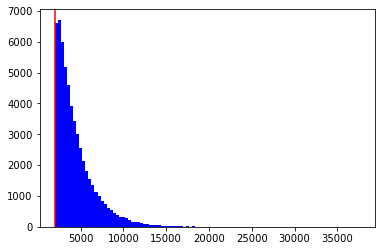

Oligodendrocytes                                                        15866
Cortical projection neurons; mouse                                      13903
Vascular; mouse                                                          6475
D1 Medium Spiny Neurons; mouse                                           2126
Astrocytes; mouse                                                        2049
Excitatory neurons, hippocampus CA1                                      1877
D2 Medium Spiny Neurons; mouse                                           1859
Immune cells; mouse                                                      1595
R-LM border Cck interneurons, cortex/hippocampus                         1181
Inhibitory neurons, septal nucleus                                       1003
Hippocamposeptal projection, cortex/hippocampus                           998
Interneuron-selective interneurons, cortex/hippocampus                    905
CGE-derived neurogliaform cells, cortex/hippocampus             

In [14]:
# filter cells by transcript numbers
min_transcripts = 2000

adata_selected.obs['n_transcripts'] = np.sum(adata_selected.X, axis=1)

plt.hist(adata_selected.obs['n_transcripts'].to_numpy(), bins=100, color='blue')
plt.axvline(min_transcripts, color='red')
plt.show()

print(adata_selected.obs['Celltype_assigned'].value_counts())

adata_selected_filt = adata_selected[adata_selected.obs['n_transcripts'] >= min_transcripts, :]

plt.hist(adata_selected_filt.obs['n_transcripts'].to_numpy(), bins=100, color='blue')
plt.axvline(min_transcripts, color='red')
plt.show()

adata_selected_filt.obs['Celltype_assigned'].value_counts()

In [15]:
adata_selected_filt.obs_names_make_unique()

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [132]:
adata_all[adata_all.obs['Region'] == 'Hypothalamus,Thalamus,Midbrain dorsal,Midbrain ventral,Pons,Medulla,Spinal cord', :].obs['Celltype_assigned'].value_counts()

Astrocytes, protoplasmic; mouse    6642
Astrocytes, fibrous; mouse         2568
Name: Celltype_assigned, dtype: int64

In [16]:
# Number of cells coming from regions
print(adata_selected_filt.obs['Region'].value_counts())

# Number of different cell types in these regions
adata_selected_filt.obs['Celltype_assigned'].value_counts()

CNS                                                                                24595
Cortex                                                                             13903
Hippocampus,Cortex                                                                  6454
Striatum ventral                                                                    2527
Hippocampus                                                                         2317
Striatum dorsal                                                                     1690
Telencephalon                                                                       1077
Striatum dorsal, Striatum ventral                                                   1003
Amygdala                                                                             795
Hypothalamus,Thalamus,Midbrain dorsal,Midbrain ventral,Pons,Medulla,Spinal cord      559
Striatum dorsal, Striatum ventral, Dentate gyrus                                     556
Midbrain dorsal      

Oligodendrocytes                                                        15866
Cortical projection neurons; mouse                                      13903
Vascular; mouse                                                          6475
D1 Medium Spiny Neurons; mouse                                           2126
Astrocytes; mouse                                                        2049
Excitatory neurons, hippocampus CA1                                      1877
D2 Medium Spiny Neurons; mouse                                           1859
Immune cells; mouse                                                      1595
R-LM border Cck interneurons, cortex/hippocampus                         1181
Inhibitory neurons, septal nucleus                                       1003
Hippocamposeptal projection, cortex/hippocampus                           998
Interneuron-selective interneurons, cortex/hippocampus                    905
CGE-derived neurogliaform cells, cortex/hippocampus             

In [17]:
export_name = f'{output_folder}L5_CTX_M_STR_description_selection_2000_astmerged'

In [18]:
adata_selected_filt.obs['Sample'] = 'Linnarsson'
adata_selected_filt.obs

,Age,AnalysisPool,CellID,Class,ClusterName,Description,Location_based_on,Mean Reads per Cell,Median UMI Counts per Cell,Neurotransmitter,...,bio_celltype,ChipID,SampleID,SampleIndex,PCRCycles,Strain,Celltype_assigned,value,n_transcripts,Sample
CellID,,,,,,,,,,,,,,,,,,,,,
10X54_8_TGAGCCACGGACAA-,p21,,10X54_8_TGAGCCACGGACAA-,Oligos,MFOL1,Myelin forming oligodendrocytes (MFOL),Vip,,,,...,Oligos,10X54,10X54_8,SI-GA-H1,13,CD-1,Oligodendrocytes,0,3546.0,Linnarsson
10X54_8_AGAAGAGCTATGCT-,p21,,10X54_8_AGAAGAGCTATGCT-,Oligos,MFOL1,Myelin forming oligodendrocytes (MFOL),Vip,,,,...,Oligos,10X54,10X54_8,SI-GA-H1,13,CD-1,Oligodendrocytes,0,4099.0,Linnarsson
10X54_8_CGGGATCGTTGCCT-,p21,,10X54_8_CGGGATCGTTGCCT-,Oligos,MFOL1,Myelin forming oligodendrocytes (MFOL),Vip,,,,...,Oligos,10X54,10X54_8,SI-GA-H1,13,CD-1,Oligodendrocytes,0,4393.0,Linnarsson
10X54_8_CCAAGTCATTGCCC-,p21,,10X54_8_CCAAGTCATTGCCC-,Oligos,MFOL1,Myelin forming oligodendrocytes (MFOL),Vip,,,,...,Oligos,10X54,10X54_8,SI-GA-H1,13,CD-1,Oligodendrocytes,0,3535.0,Linnarsson
10X54_8_GACGTGTCTACCTC-,p21,,10X54_8_GACGTGTCTACCTC-,Oligos,MFOL1,Myelin forming oligodendrocytes (MFOL),Vip,,,,...,Oligos,10X54,10X54_8,SI-GA-H1,13,CD-1,Oligodendrocytes,0,3163.0,Linnarsson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X52_2_TAGACTCGCCTT-,p20,,10X52_2_TAGACTCGCCTT-,Astrocytes,ACMB,Dorsal midbrain Myoc-expressing astrocyte-like,"Drd1,Tac1 and dissection region",,,,...,Astrocytes,10X52,10X52_2,SI-3A-B10,13,CD-1,Astrocytes; mouse,0,2292.0,Linnarsson
10X52_4_AGCGTGATTCGG-,p20,,10X52_4_AGCGTGATTCGG-,Astrocytes,ACMB,Dorsal midbrain Myoc-expressing astrocyte-like,"Drd1,Tac1 and dissection region",,,,...,Astrocytes,10X52,10X52_4,SI-3A-D10,13,CD-1,Astrocytes; mouse,0,2341.0,Linnarsson
10X57_3_CGAGTGTTGAGC-,p25-27,,10X57_3_CGAGTGTTGAGC-,Astrocytes,ACMB,Dorsal midbrain Myoc-expressing astrocyte-like,"Drd1,Tac1 and dissection region",,,,...,Astrocytes,10X57,10X57_3,SI-3A-H1,13,Swiss,Astrocytes; mouse,0,2735.0,Linnarsson


In [19]:
adata_selected_filt.write_h5ad(f'{export_name}.h5ad')

In [20]:
with open(f'{export_name}.pkl', 'wb') as export:
    pickle.dump(adata_selected_filt, export)

In [9]:
with open(f'{export_name}.pkl', 'rb') as imported:
    adata_selected_filt = pickle.load(imported)
adata_selected_filt

AnnData object with n_obs × n_vars = 68087 × 27794
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'SampleIndex', 'PCRCycles', 'Strain', 'Celltype_assigned', 'value', 'n_transcripts', 'Sample'
    var: 'Accession', 'Gene', 'Gene_no_alt'
    uns: 'merged'

In [42]:
def subsample_anndata(anndata, annot_column='Celltype_assigned', counts=[50, 500]):
    print(f'Dataset will be downsampled to contain between {counts[0]} and {counts[1]} cells per celltype')
    anndata_subset = anndata.copy()
    cells_to_keep = []

    for x in anndata_subset.obs[annot_column].unique():
        print(x)
        all_cells = anndata_subset.obs[anndata_subset.obs[annot_column] == x]['CellID'].to_list()
        if len(all_cells) < counts[0]:
            anndata_subset = anndata_subset[anndata_subset.obs[annot_column] != x, :]
            print(f'{x} with {len(all_cells)} cells will be dropped')
        elif len(all_cells) >= counts[0] and len(all_cells) <= counts[1]:
            cells_to_keep += all_cells
            print(f'All {len(all_cells)} cells will be used')
        elif len(all_cells) > counts[1]:
            cells_that_won_the_lottery = np.random.choice(all_cells, size=counts[1], replace=False).tolist()
            print(f'{len(cells_that_won_the_lottery)} cells will be kept out of {len(all_cells)}')
            cells_to_keep += cells_that_won_the_lottery
    
    anndata_subset = anndata_subset[anndata_subset.obs['CellID'].isin(cells_to_keep), :]
    print(anndata_subset.obs[annot_column].value_counts())
    
    return anndata_subset

In [45]:
adata_selected_subset = subsample_anndata(adata_selected_filt, annot_column='Celltype_assigned', counts=[50, 500])

Dataset will be downsampled to contain between 50 and 500 cells per celltype
Oligodendrocytes
500 cells will be kept out of 16336
Cortical projection neurons; mouse
500 cells will be kept out of 14624
Excitatory neurons, amygdala
500 cells will be kept out of 871
Excitatory neurons, hippocampus CA3
All 455 cells will be used
Excitatory neurons, hippocampus CA1
500 cells will be kept out of 1978
R-LM border Cck interneurons, cortex/hippocampus
500 cells will be kept out of 1227
Non-border Cck interneurons, cortex/hippocampus
All 279 cells will be used
Interneuron-selective interneurons, cortex/hippocampus
500 cells will be kept out of 1071
CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus
All 383 cells will be used
Ivy and MGE-derived neurogliaform cells, cortex/hippocampus
500 cells will be kept out of 617
CGE-derived neurogliaform cells, cortex/hippocampus
500 cells will be kept out of 978
Hippocamposeptal projection, cortex/hippocampus
500 cells will be kept out of 1029
Sle

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [51]:
adata_selected_subset.X

array([[0., 0., 0., ..., 0., 0., 1.],
       [4., 1., 0., ..., 0., 3., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [44]:
adata_selected_subset = adata_selected

In [11]:
adata_selected_subset.raw = adata_selected_subset.copy()
sc.pp.normalize_per_cell(adata_selected_subset)
sc.pp.log1p(adata_selected_subset)

In [12]:
sc.pp.neighbors(adata_selected_subset)
sc.tl.pca(adata_selected_subset)
sc.tl.umap(adata_selected_subset)

         Falling back to preprocessing with `sc.pp.pca` and default params.


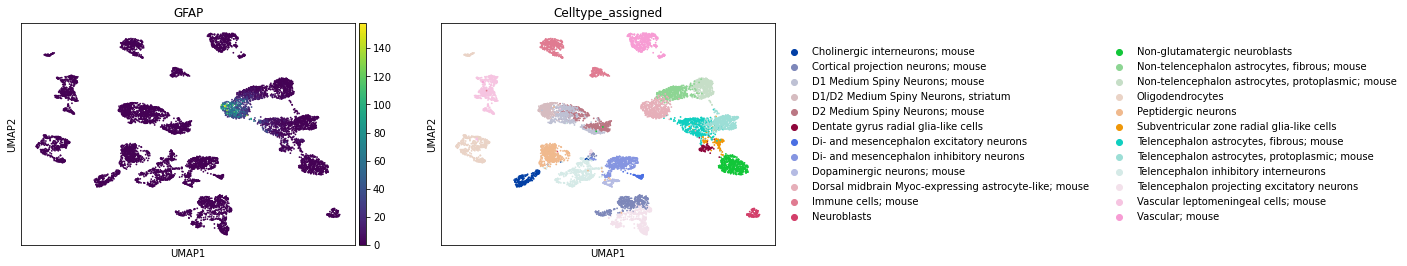

In [13]:
sc.pl.umap(adata_selected_subset, color=['GFAP', 'Celltype_assigned'])

In [205]:
[x for x in adata_selected_subset.var.index if x.upper() != x ]

[]

In [46]:
export_name_subset = f'{export_name}_subset_50-500'
export_name_subset

'../../data/stereoscope_reference/single_cell_data/L5_061022/L5_CTX_M_STR_descriptionr_selection_subset_50-500'

In [47]:
adata_selected_subset.obs_names_make_unique()

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [48]:
adata_selected_subset.obs_names.value_counts().value_counts()

1    14531
Name: CellID, dtype: int64

In [49]:
adata_selected_subset.write_h5ad(f'{export_name_subset}.h5ad')

In [50]:
with open(f'{export_name_subset}.pkl', 'wb') as export:
    pickle.dump(adata_selected_subset, export)